투빅스 12회 추천 컨퍼런스 Img2Seq(Show And Tell) 의 코드 정리입니다.

`Kor2Vec` 과 `pytorch` 를 사용했습니다.

# 기본 다운로드 및 임포트

In [1]:
!pip install git+https://github.com/naver/kor2vec.git

  Cloning https://github.com/naver/kor2vec.git to /tmp/pip-req-build-03jwagiv
  Running command git clone -q https://github.com/naver/kor2vec.git /tmp/pip-req-build-03jwagiv
  Created wheel for kor2vec: filename=kor2vec-1.0.1-cp37-none-any.whl size=21946 sha256=20711a8ea56c3e435a77ecfb23426c453ec3d23923966372caff80262941be62
  Stored in directory: /tmp/pip-ephem-wheel-cache-24yfhfky/wheels/b7/74/03/492f7af08e1f00c56765b0f6a25f28a086cc23db1827f269a4
Successfully built kor2vec


In [8]:
from kor2vec import Kor2Vec # Kor2Vec import

import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torchvision.models as models # 임베딩 모델
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 기본 변수 정의

In [3]:
# 리뷰 테이블 읽어오기
review = pd.read_csv('/content/drive/MyDrive/Datasets/cafe_review_tag.csv', encoding='cp949')

# 잘못된 이미지 파일 제거
review.drop([197,754,4470], inplace=True)
review.dropna(inplace=True)
review = review.reset_index(drop = True)

In [4]:
# 리뷰 데이터를 사용해 임베딩을 학습 실시

rev = pd.Series("<sos> " + review['review'])
rev.to_csv("review_corpus.csv")


kor2vec = Kor2Vec(embed_size=1000) # embed_size : 임베딩 벡터의 2번째 차원(차원 수)
"""
train([텍스트 데이터 파일 - 위에서 저장, 모델 저장 위치, 학습 배치 사이즈])
"""
kor2vec.train("review_corpus.csv", 'model.kor2vec', batch_size=128) # 임베딩 실시 (학습)
kor2vec.save("/content/drive/MyDrive/koremb_tobigs/embedding") # 임베딩 모델 저장

Corpus Sampling:   0%|          | 0/19839 [00:00<?, ?it/s]

Reading Corpus lines


Corpus Sampling: 100%|██████████| 19839/19839 [00:00<00:00, 25446.37it/s]


Training kor2vec
Loading Word_sample corpus
Loading corpus finished
CUDA Available/count: True 1
training on  cuda:0


EP 1:   0%|          | 2/969 [00:00<00:52, 18.53it/s]

{'epoch': 0, 'train_ep_loss': 3.854360596314303}


EP 2:   0%|          | 2/969 [00:00<00:50, 19.22it/s]

{'epoch': 1, 'train_ep_loss': 1.4594630137070537}


EP 3:   0%|          | 2/969 [00:00<00:53, 18.22it/s]

{'epoch': 2, 'train_ep_loss': 1.3649889566580946}


EP 4:   0%|          | 2/969 [00:00<00:49, 19.68it/s]

{'epoch': 3, 'train_ep_loss': 1.279802244944715}


EP 5:   0%|          | 2/969 [00:00<00:50, 19.30it/s]

{'epoch': 4, 'train_ep_loss': 1.1768679972526581}


EP 6:   0%|          | 2/969 [00:00<00:49, 19.40it/s]

{'epoch': 5, 'train_ep_loss': 1.0868745881091453}


EP 7:   0%|          | 2/969 [00:00<00:51, 18.63it/s]

{'epoch': 6, 'train_ep_loss': 1.0102501621064264}


EP 8:   0%|          | 2/969 [00:00<00:49, 19.69it/s]

{'epoch': 7, 'train_ep_loss': 0.9413056622102657}


EP 9:   0%|          | 2/969 [00:00<00:57, 16.92it/s]

{'epoch': 8, 'train_ep_loss': 0.8807255847166198}


EP 9: 100%|██████████| 969/969 [00:52<00:00, 18.60it/s]


{'epoch': 9, 'train_ep_loss': 0.822650854924638}


In [5]:
!unzip -O cp949 -q /content/drive/MyDrive/Datasets/img_preprocess_final_20210615.zip -d data

1945카페_1.jpg:  mismatching "local" filename (1945移댄럹_1.jpg),
         continuing with "central" filename version
1945카페_2.jpg:  mismatching "local" filename (1945移댄럹_2.jpg),
         continuing with "central" filename version
1945카페_3.jpg:  mismatching "local" filename (1945移댄럹_3.jpg),
         continuing with "central" filename version
298카페_1.jpg:  mismatching "local" filename (298移댄럹_1.jpg),
         continuing with "central" filename version
298카페_2.jpg:  mismatching "local" filename (298移댄럹_2.jpg),
         continuing with "central" filename version
298카페_3.jpg:  mismatching "local" filename (298移댄럹_3.jpg),
         continuing with "central" filename version
8커피_1.jpg:  mismatching "local" filename (8而ㅽ뵾_1.jpg),
         continuing with "central" filename version
8커피_2.jpg:  mismatching "local" filename (8而ㅽ뵾_2.jpg),
         continuing with "central" filename version
8커피_3.jpg:  mismatching "local" filename (8而ㅽ뵾_3.jpg),
         continuing with "central" filename version
FOURB 강

In [10]:
class CaptionDataset(Dataset):
    """
    root_dir : 이미지 파일이 있는 경로
    captions_file : 이미지 제목-리뷰가 포함된 데이터프레임
    transform : 이미지를 텐서로 변환할 때 transform (optional)
    """
    def __init__(self, img_dir, caption_df, transform=None):
        self.root_dir = img_dir
        self.transform = transform
        self.df = caption_df
        
        self.imgs = self.df['imgname_123'] # 이미지 파일 경로
        self.captions = self.df["review"] # 리뷰 데이터
        self.kor2vec = Kor2Vec.load("/content/drive/MyDrive/koremb_tobigs/embedding") # Kor2Vec 로드
        
    
    def __len__(self):
        return len(self.df)
    
    # 이미지, 텍스트를 불러 오는 메소드
    # transform을 선언하면 임베딩 벡터와 1개 배치로 반환하며, 선언하지 않으면 이미지와 스트링 형태의 캡션을 반환합니다.
    def __getitem__(self,idx):
        caption = self.captions[idx] # target caption
        
        img_name = self.imgs[idx] # 이미지 이름 파일 불러오기
        img_location = os.path.join(self.root_dir,img_name) # 실제로 이미지 오픈
        img = Image.open(img_location).convert("RGB")
        
        # transform이 있다면 실시 후 배치화(1 차원 추가)
        if self.transform is not None:
          img = self.transform(img)
          img = img.unsqueeze(0)
          # 정답 임베딩 데이터 
          # seq_len을 15로 통일하고자 합니다.
          caption = self.kor2vec.embedding(caption, seq_len=15)

        return img, caption

In [7]:
class Net(nn.Module):
  """
  신경망 파일
  hidden_size : kor2vec의 embedding size 로 맞춰야 합니다.
  """
  def __init__(self, hidden_size = 1000):
    super(Net, self).__init__()
    self.hidden_size = hidden_size
    self.resnet = models.resnet18(pretrained=True)
    self.lstm = nn.LSTM(input_size = self.hidden_size, hidden_size=self.hidden_size, batch_first=False)


    # resNet의 모든 파라미터를 잠그고 마지막 레이어만 얼리지 않고 사용합니다.
    for param in self.resnet.parameters():
       param.requires_grad = False
    self.resnet.fc.requires_grad = True # 마지막 레이어만 다시 사용합니다.

  def forward(self, x):
    x = self.resnet(x) # resnet 통과 output: (batch, hidden)

    hidden = (x.reshape(1,1,self.hidden_size),x.reshape(1,1,self.hidden_size)) # lstm의 초기 셀 값은 resNet의 출력입니다.
    outputs = torch.zeros(15, 1, self.hidden_size).to(device) # sequence를 저장하기 위한 빈 배열
    

    # <sos> 를 시작 토큰으로 설정합니다.
    output = kor2vec.embedding('<sos>').reshape(1, 1, self.hidden_size).to(device)

    # seq 결과물을 lstm의 입력으로 사용하여 seq_len = 15 만큼 반복하여 저장합니다.
    for t in range(0, 15):
        output, hidden = self.lstm(output, hidden) 
        outputs[t] = output

    return outputs # shape: (15, 1, 1000)

# 실제 코드 불러와서 사용

매장이 넓어서 가디 근처에 조용한 카페 찾을때 좋을듯. 흑임자라떼 맛있음


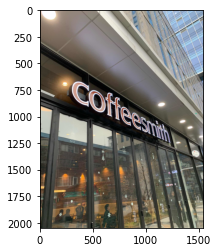

In [12]:
# 이미지 표시 : transform을 None으로 놓고 사용
img_data = CaptionDataset('/content/data', review, transform=None)
img, rev = img_data[6666]

print(rev)
plt.imshow(img)
plt.show()

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 텐서로 변형
     transforms.Resize(224), # 사이즈 조절
     transforms.CenterCrop(224), # 가로와 세로 중 안 맞는 곳 자르기
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
train_data = CaptionDataset('/content/data', review, transform=transform)

img, rev = train_data[0]

print(f"img shape : {img.shape}") # ([1, 3, 224, 224]) - [배치, 채널, 가로, 세로]
print(f"rev : {rev.shape}") # ([15, 1000]) - [seq_len, hidden_size]

img shape : torch.Size([1, 3, 224, 224])
rev : torch.Size([15, 1000])


In [20]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model.to(device)

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [24]:
# 신경망 학습
for epoch in range(10): # 10에포크
  running_loss = 0.0

  for i, data in enumerate(train_data, 0):
    img, label = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    output = model(img)

    # shape: (15, 1, 1000) 이므로 label (15, 1000)과 차원을 맞춰 줍니다.
    loss = criterion(output.squeeze(1), label.to(device))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    if i>= len(train_data): break # 왜인지 모르겠으나 묵시적으로 enumerate가 종료되지 않아서 명시적으로 추가
    
    if (i % 10) == 0: # 매 100번 미니배치마다 출력하기
            print('[%d, %5d] loss: %.3f' %
                  (epoch +1, i+1, running_loss / (i + 1)))
            running_loss =0.0

[1,     1] loss: 0.121
[1,    11] loss: 0.084
[1,    21] loss: 0.043
[1,    31] loss: 0.043
[1,    41] loss: 0.021
[1,    51] loss: 0.021
[1,    61] loss: 0.018
[1,    71] loss: 0.018
[1,    81] loss: 0.015
[1,    91] loss: 0.014
[1,   101] loss: 0.011
[1,   111] loss: 0.010
[1,   121] loss: 0.008
[1,   131] loss: 0.010
[1,   141] loss: 0.007
[1,   151] loss: 0.006
[1,   161] loss: 0.007
[1,   171] loss: 0.009
[1,   181] loss: 0.007
[1,   191] loss: 0.004
[1,   201] loss: 0.005
[1,   211] loss: 0.006
[1,   221] loss: 0.005
[1,   231] loss: 0.005
[1,   241] loss: 0.006
[1,   251] loss: 0.004
[1,   261] loss: 0.004
[1,   271] loss: 0.004
[1,   281] loss: 0.003
[1,   291] loss: 0.004
[1,   301] loss: 0.004
[1,   311] loss: 0.005
[1,   321] loss: 0.003
[1,   331] loss: 0.004
[1,   341] loss: 0.003
[1,   351] loss: 0.003
[1,   361] loss: 0.004
[1,   371] loss: 0.003
[1,   381] loss: 0.003
[1,   391] loss: 0.003
[1,   401] loss: 0.002
[1,   411] loss: 0.002
[1,   421] loss: 0.003
[1,   431] 

KeyboardInterrupt: ignored